In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import BoundaryNorm
from statsmodels.stats.weightstats import ttest_ind
from matplotlib.colors import ListedColormap
import pandas as pd

def perform_ttest(feature_names: list, df: pd.DataFrame, n_tests: int):
    d = {'E-N': {}, 'C-N': {}, 'E-C': {}}
    for col in feature_names:
        strong = df[df['Outcome'] == 'Strong'][col].dropna().sort_values().tolist()
        cyto = df[df['Outcome'] == 'Cyto'][col].dropna().sort_values().tolist()
        no = df[df['Outcome'] == 'No-Effect'][col].dropna().sort_values().tolist()
        _, strong_no_p, _ = ttest_ind(strong, no)
        _, strong_cyto_p, _ = ttest_ind(strong, cyto)
        _, cyto_no_p, _ = ttest_ind(cyto, no)
        d['E-N'][col] = strong_no_p * n_tests
        d['E-C'][col] = strong_cyto_p * n_tests
        d['C-N'][col] = cyto_no_p * n_tests
    results = pd.DataFrame.from_dict(d).T
    results.columns = results.columns.str.replace('Count', 's')
    return results

target_db = "DC"
network_type = "large"

In [2]:
features_combined = pd.read_csv(f'../../../2_feature_extraction/{network_type}/features_{target_db} Target.csv', index_col=0)
structure_feature_names = features_combined.columns[1:27]
target_feature_names = [feature for feature in features_combined.columns if "target" in feature and "cov" not in feature and not "mercator" in feature]
neighbor_feature_names = [feature for feature in features_combined.columns if "neighbor" in feature and "cov" not in feature and not "mercator" in feature]
covidome_feature_names = [feature for feature in features_combined.columns if "cov" in feature]

features_combined['Outcome'] = features_combined['Outcome'].replace({'Weak': 'Strong'})
features_combined = features_combined.drop(['Target', 'Neighbor'], axis=1)
display(features_combined.columns.tolist())
len(features_combined.columns.tolist())

['Outcome',
 'MolecularWeight',
 'MonoisotopicMass',
 'ExactMass',
 'XLogP',
 'TPSA',
 'Complexity',
 'Charge',
 'HBondDonorCount',
 'HBondAcceptorCount',
 'RotatableBondCount',
 'HeavyAtomCount',
 'AtomStereoCount',
 'BondStereoCount',
 'CovalentUnitCount',
 'Volume3D',
 'XStericQuadrupole3D',
 'YStericQuadrupole3D',
 'ZStericQuadrupole3D',
 'FeatureCount3D',
 'FeatureAcceptorCount3D',
 'FeatureDonorCount3D',
 'FeatureAnionCount3D',
 'FeatureCationCount3D',
 'FeatureRingCount3D',
 'FeatureHydrophobeCount3D',
 'ConformerModelRMSD3D',
 'EffectiveRotorCount3D',
 'ConformerCount3D',
 'target_pagerank_min',
 'target_pagerank_mean',
 'target_pagerank_median',
 'target_pagerank_max',
 'neighbor_pagerank_min',
 'neighbor_pagerank_mean',
 'neighbor_pagerank_median',
 'neighbor_pagerank_max',
 'target_betweenness_min',
 'target_betweenness_mean',
 'target_betweenness_median',
 'target_betweenness_max',
 'neighbor_betweenness_min',
 'neighbor_betweenness_mean',
 'neighbor_betweenness_median',
 '

96

/Users/spaethju/.conda/envs/graph-data-science/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:650: RuntimeWarning: invalid value encountered in double_scalars
  tstat = (value1 - value2 - diff) / std_diff


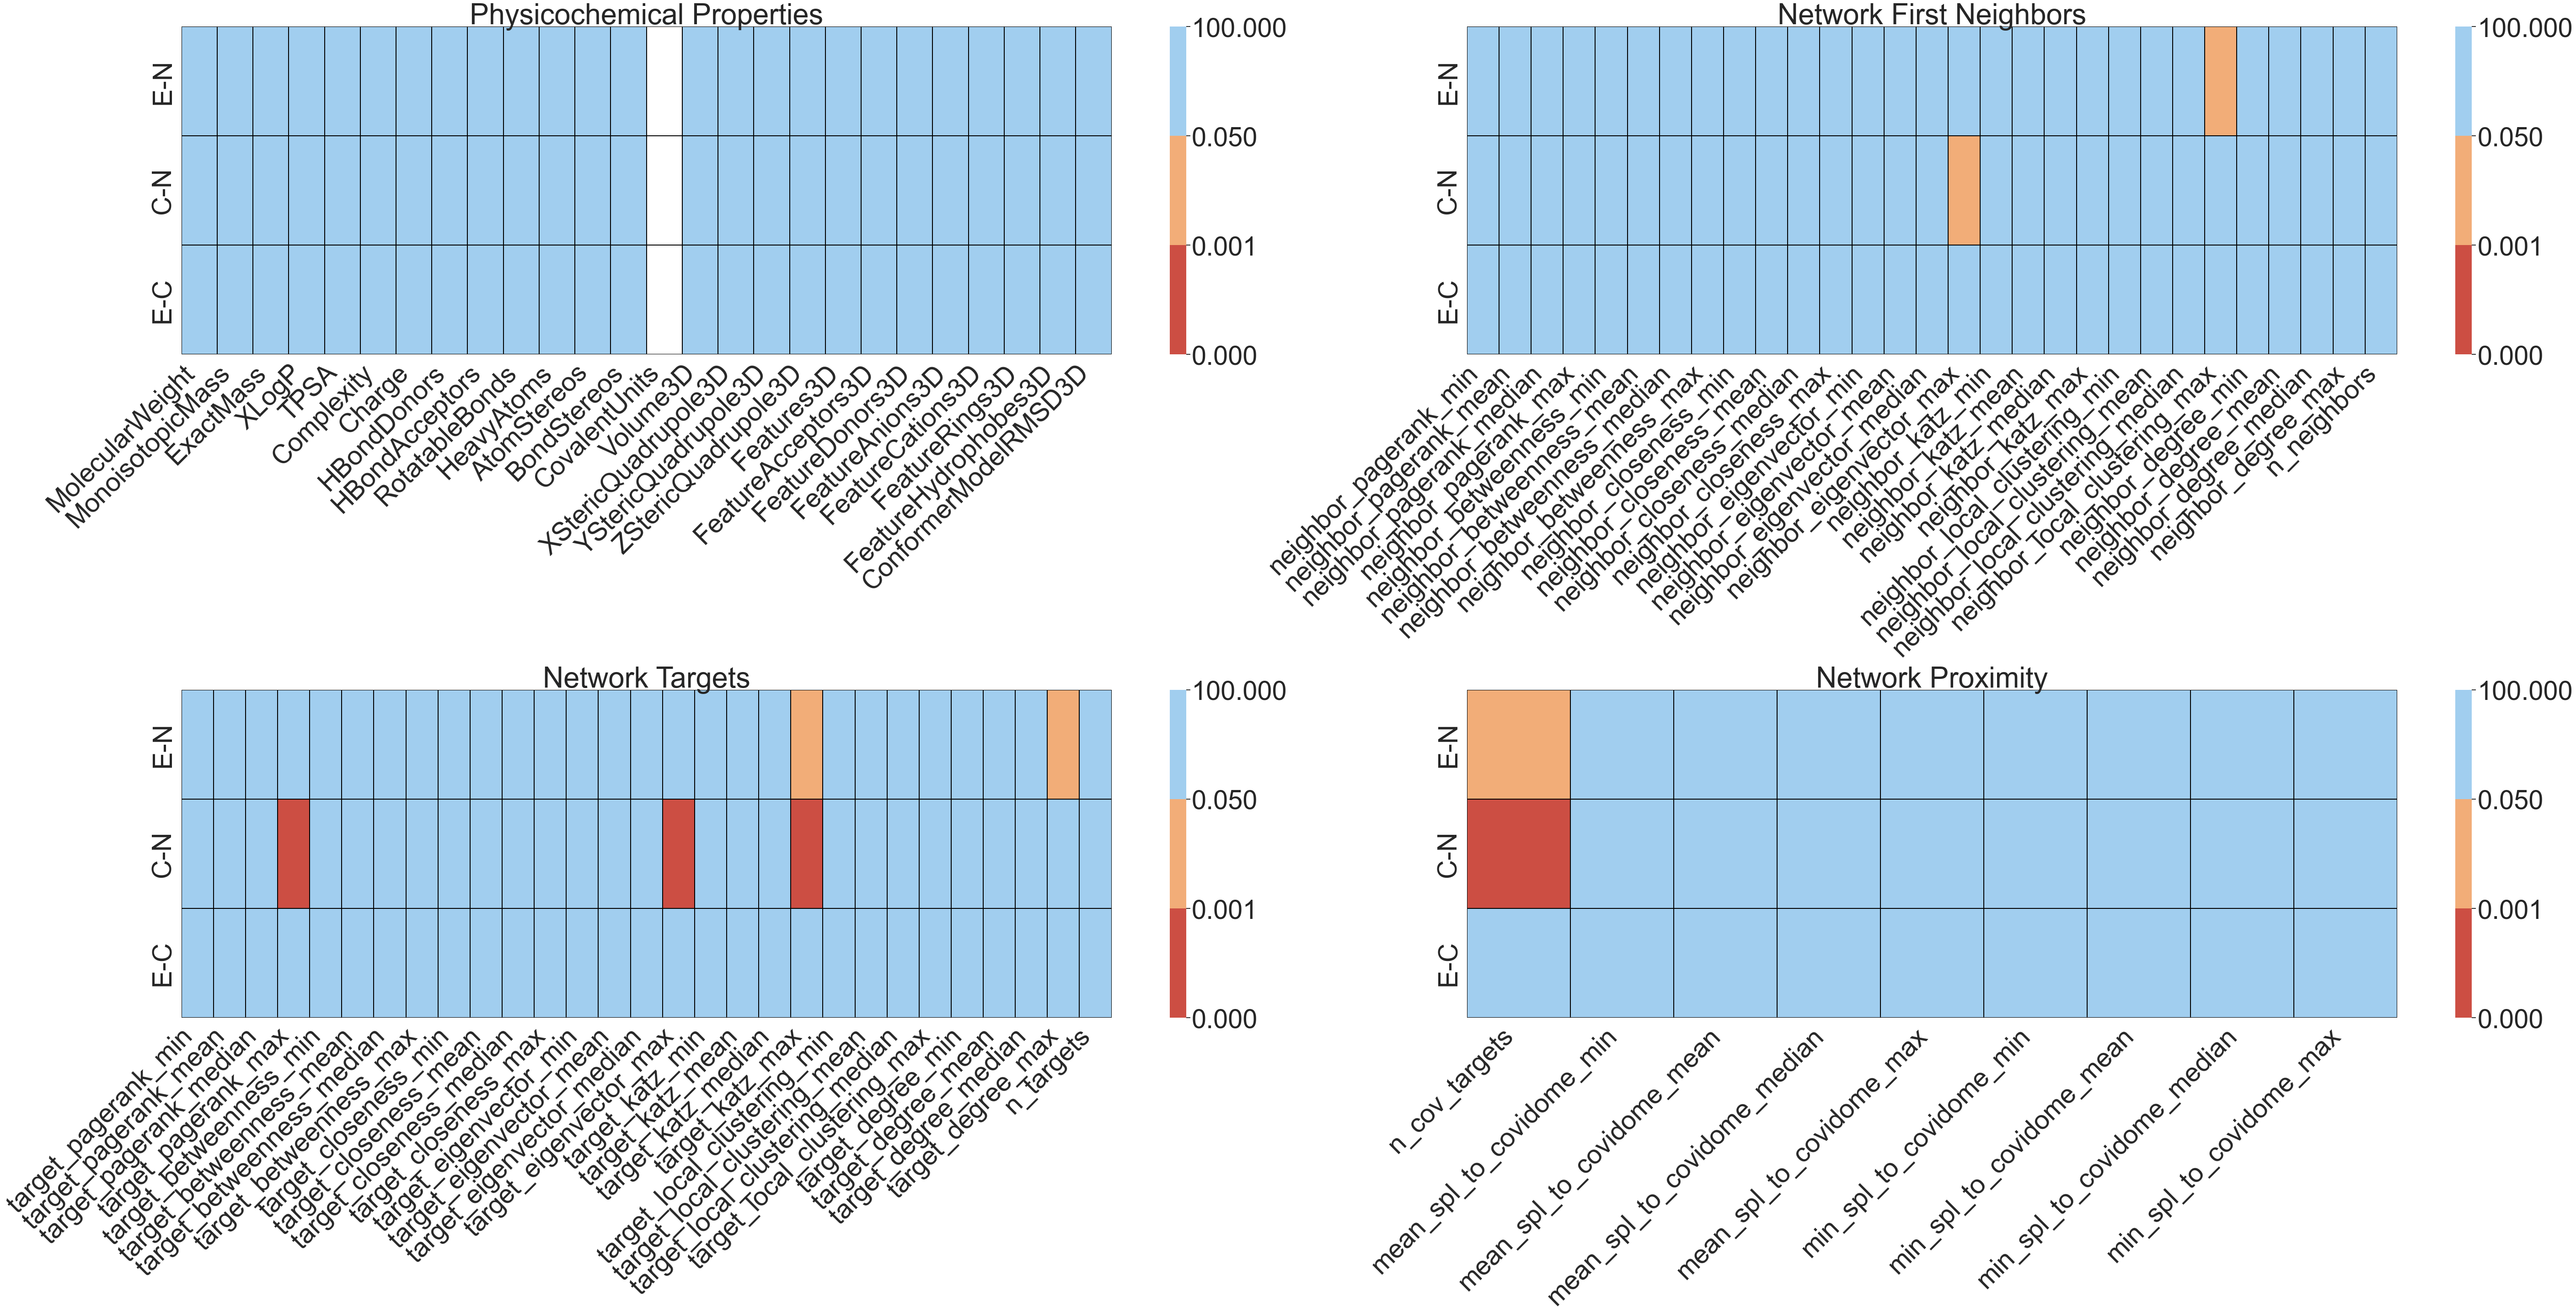

In [3]:
sns.set("talk", font_scale=3.5)
sns.set_style("whitegrid")
my_colors = ['#cc4e43', '#f2ad78', '#a1ceef']
my_cmap = ListedColormap(my_colors)
bounds = [0.0, 0.001, 0.05, 100.0]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(2, 2, figsize=(80, 40))
outcomes = features_combined.loc[:, 'Outcome']
df = features_combined.copy()
df.loc[:, 'Outcome'] = outcomes

features_combined = features_combined.loc[:, [x for x in features_combined.columns if "mercator" not in x]]
n_tests = len(features_combined.columns.tolist()[1:])

# Structure features
results = perform_ttest(structure_feature_names, df, n_tests)
sns.heatmap(data=results, ax=axes[0, 0], cmap=my_cmap, norm=my_norm, cbar_kws=dict(format='%.3f'), linewidths=2, linecolor='black')
plt.tight_layout()
# Target features
results = perform_ttest(target_feature_names, df, n_tests)
sns.heatmap(data=results, ax=axes[1, 0], cmap=my_cmap, norm=my_norm, cbar_kws=dict(format='%.3f'), linewidths=2, linecolor='black')
plt.tight_layout()
# Neighbor features
results = perform_ttest(neighbor_feature_names, df, n_tests)
sns.heatmap(data=results, ax=axes[0, 1], cmap=my_cmap, norm=my_norm, cbar_kws=dict(format='%.3f'), linewidths=2, linecolor='black')
plt.tight_layout()
# Cov features
results = perform_ttest(covidome_feature_names, df, n_tests)
sns.heatmap(data=results, ax=axes[1, 1], cmap=my_cmap, norm=my_norm, cbar_kws=dict(format='%.3f'), linewidths=2, linecolor='black')
plt.tight_layout()

fontsize = 16
fontweight = "bold"
axes[0, 0].title.set_text('Physicochemical Properties')
axes[1, 0].title.set_text('Network Targets')
axes[0, 1].title.set_text('Network First Neighbors')
axes[1, 1].title.set_text('Network Proximity')
fig.autofmt_xdate(rotation=45)
plt.tight_layout()

fig.savefig('heatmap.pdf', dpi=300, format='pdf')
fig.savefig('heatmap.png', dpi=300, format='png')
fig.savefig('heatmap.eps', dpi=300, format='eps')
fig.savefig('heatmap.svg', dpi=300, format='svg')